In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv1D,Conv2D, MaxPooling2D,AveragePooling2D,GlobalMaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation,Flatten,Dropout,Dense
from tensorflow.keras import activations
from keras.layers import Concatenate,Add,Multiply,Reshape,Lambda
from keras.models import Model
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras import Input
from keras.layers import UpSampling2D
from tensorflow import expand_dims,squeeze

In [ ]:
def generator(img_dir,msk_dir):
    imggen=ImageDataGenerator()
    mskgen=ImageDataGenerator()

    img_gen=imggen.flow_from_directory(directory=img_dir,class_mode=None,shuffle=False,color_mode='grayscale',seed=10,target_size=(224,224))
    msk_gen=mskgen.flow_from_directory(directory=msk_dir,class_mode=None,shuffle=False,color_mode='grayscale',seed=10,target_size=(224,224))

    gen=zip(img_gen,msk_gen)

    for (img,msk) in gen:
        yield (img,msk)


In [ ]:
train_img_dir=r'/content/drive/MyDrive/Output/train/Image'
train_msk_dir=r'/content/drive/MyDrive/Output/train/Mask'


val_img_dir=r'/content/drive/MyDrive/Output/val/Image'
val_msk_dir=r'/content/drive/MyDrive/Output/val/Mask'

train_gen=generator(train_img_dir,train_msk_dir)
val_gen=generator(val_img_dir,val_msk_dir)

In [ ]:
x_train,y_train=train_gen.__next__()
x_test,y_test=val_gen.__next__()

Found 1521 images belonging to 1 classes.
Found 1521 images belonging to 1 classes.
Found 381 images belonging to 1 classes.
Found 381 images belonging to 1 classes.


In [ ]:
# model
def channel_attention(input,units):
  channel = input.shape[-1]
  shared_layer_one = Dense(channel//8,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')

  shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')

  max=GlobalMaxPooling2D()(input)
  max=Reshape((1,1,channel))(max)
  max = shared_layer_one(max)
  max = shared_layer_two(max)



  avg=GlobalAveragePooling2D()(input)
  avg=Reshape((1,1,channel))(avg)
  avg = shared_layer_one(avg)
  avg = shared_layer_two(avg)

  input=Add()([max,avg])
  input=Activation('relu')(input)

  return input

def unsqueeze(input):
    return expand_dims(input)

def ssqueeze(input):
    return squeeze(input)

def spatial_attention(input,units):
  max=MaxPooling2D((2,2))(input)
  avg=AveragePooling2D((2,2))(input)
  input=Concatenate()([max,avg])
  input=Conv2D(units,(3,3),padding='same')(input)
  input=BatchNormalization()(input)
  input=Activation('relu')(input)
  input=UpSampling2D(size=(2,2))(input)
  return input

def CBAM(input,units):
  chattn=channel_attention(input,units)
  input=Multiply()([chattn,input])
  spattn=spatial_attention(input,units)
  input=Multiply()([spattn,input])
  return input

def conv(units,input):
  x=BatchNormalization()(input)
  x=Activation('relu')(x)
  x=Conv2D(units,(3,3),padding='same')(x)


  x=BatchNormalization()(x)
  x=Activation('relu')(x)
  x=Conv2D(units,(3,3),padding='same')(x)

  short=Conv2D(units,(3,3),padding='same')(input)
  short=BatchNormalization()(short)
  x=Add()([short,x])

  return x

def encoder(units,input):
  x=conv(units,input)
  p=MaxPooling2D((2,2))(x)
  return x,p

def decoder(units,input,skips):
  x=UpSampling2D(size=(2,2))(input)
  x=conv(units,x)
  skips=CBAM(skips,units)
  x=Concatenate()([x,skips])

  return x

def conv2(units,input):
  x=Conv2D(units,(3,3),padding='same')(input)


  x=BatchNormalization()(x)
  x=Activation('relu')(x)
  x=Conv2D(units,(3,3),padding='same')(x)

  short=Conv2D(units,(3,3),padding='same')(input)
  short=BatchNormalization()(short)
  x=Add()([short,x])

  return x


def encoderV2(units,input):
  x=conv2(units,input)
  # p=MaxPooling2D((2,2))(x)
  return x

def Res_Unet(input_shape):
  inputs=Input(input_shape)
  e1=encoderV2(16,inputs)
  e2,p2=encoder(32,e1)
  e3,p3=encoder(64,p2)
  e4,p4=encoder(128,p3)

  bridge=conv(256,p4)
  bridge=MaxPooling2D((2,2))(bridge)

  d1=decoder(128,bridge,p4)
  d2=decoder(64,d1,p3)
  d3=decoder(32,d2,p2)
  d4=decoder(16,d3,e1)

  output=Conv2D(1,(1,1),activation='sigmoid')(d4)

  model=Model(inputs,output,name='Res-U-Net')

  return model



In [ ]:
res_unet=Res_Unet((224,224,1))
res_unet.summary()
# Check size of input after each convolution

Model: "Res-U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                         

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import losses
from tensorflow.python.keras import backend as K

In [ ]:
def dice_coef2(y_true, y_pred, smooth=1.0):
    #y_true_f = K.flatten(y_true)
    y_true = tf.where(y_true > 0.5, K.ones_like(y_true), K.zeros_like(y_true))
    #y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    sum = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean((2. * intersection + smooth) / (sum + smooth), axis=0)

In [ ]:
def dice_coef2_loss(y_true, y_pred, smooth=1.0):
    return 1-dice_coef2(y_true, y_pred, smooth)

In [ ]:
opt=tf.keras.optimizers.Adam(learning_rate=1e-3)
res_unet.compile(loss=dice_coef2_loss,optimizer=opt,metrics=[dice_coef2])

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/Final_Res-U-Net_Channel_on_ACDC.h5',
    save_weights_only=False,
    monitor='val_dice_coef2',
    mode='max',
    save_freq='epoch',
    save_best_only=True)

In [ ]:
history=res_unet.fit(train_gen,epochs=47,validation_data=val_gen,steps_per_epoch=32,validation_steps=11.90,callbacks=[model_checkpoint_callback])

In [ ]:
res_unet.save("Final_Res-U-Net_with_CBAM_attention_on_ACDC.h5")

dict_keys(['loss', 'dice_coef2', 'val_loss', 'val_dice_coef2'])


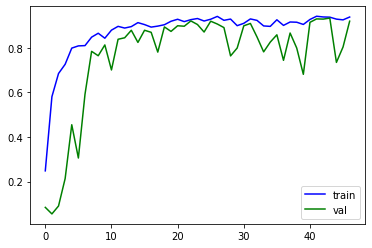

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.plot(history.history['dice_coef2'],'b')
plt.plot(history.history['val_dice_coef2'],'g')
plt.plot(xlable='epoch',ylable="loss")
plt.legend(['train','val'],loc='best')
plt.show()

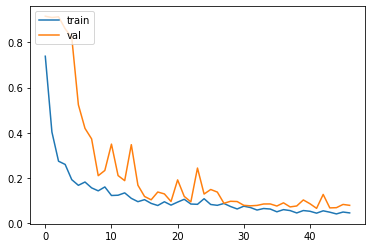

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(xlable='epoch',ylable="loss")
plt.legend(['train','val'],loc='upper left')
plt.show()